In [1]:
import sys
sys.path.append('../../')

import data.loader

(
    (train, train_y),
    (test, test_y),
    (val, val_y),
    (one_hot_encoder_X, one_hot_encoder_y),
    (train_df, test_df, _),
    (train_dataset, test_dataset, _),
    (train_loader, test_loader, _)
) = data.loader.encode_and_partition(
    data.loader.diabetic_data_raw, batch_size=64, labelled=True
)

for batch in test_loader:
    test_eval_batch = batch[0].view(-1, train.shape[1]).cuda()
    test_eval_batch_label = batch[1].cuda()
    break

import wandb
import os

# ae_encoder_run_path = "models/ae/wandb/run-20241202_115337-ugoaq6gb"
ae_encoder_run_path = "models/ae/wandb/run-20241202_131152-l5uu22fm"
# ae_encoder_run_path = "models/ae/wandb/run-20241203_144531-txqgesvz"

sys.path.append(os.path.join(ae_encoder_run_path, 'files', 'files'))
aeweights = os.path.join('../../', ae_encoder_run_path, 'files', 'autoencoder.pth')

import model

import torch
input_dim = train.shape[1]
ae = model.AutoEncoder(input_dim=input_dim, hidden_dim=128//4, latent_dim=64//4)
ae.load_state_dict(torch.load(aeweights))

/scratch/u1319464/miniforge3/envs/diabetes/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [2]:
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

transform = transforms.Compose([transforms.ToTensor()])

train_data = torch.from_numpy(train.toarray().astype(np.float32))
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_data = torch.from_numpy(test.toarray().astype(np.float32))
test_dataset = TensorDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def extract_latent_space(model, data_loader):
    model.eval()
    latent_space = []
    labels = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0].view(-1, input_dim)
            encoded = model.encoder(inputs)
            latent_space.append(encoded)
    latent_space = torch.cat(latent_space).cpu().numpy()
    return latent_space

ae.eval()
with torch.no_grad():
    latent_representations = extract_latent_space(ae, train_loader)

tsne = TSNE(n_components=2, random_state=42, perplexity=50)
latent_2d = tsne.fit_transform(latent_representations)

In [4]:
def display_tsne_labelled_panels(latent_2d, y, color_attribute, title, s=2, cmap='viridis'):
    fig, (lt30, gt30, never) = plt.subplots(1, 3, figsize=(12, 5))
    
    color_lookup = {}
    attribute_values = np.unique(color_attribute)
    for i, attribute_value in enumerate(np.sort(attribute_values)):
        color_lookup[attribute_value] = i/len(attribute_values)
    
    color_attribute = np.array([ color_lookup[i] for i in color_attribute ])
    
    plt.suptitle(f'Latent T-SNE Coloried by {title}')
    subset = y[:,0]==1
    lt30.scatter(latent_2d[subset, 0], latent_2d[subset, 1], c=color_attribute[subset], cmap=cmap, s=s)
    lt30.set_title("Admitted Again Within 30 Days")
    lt30.set_xlabel("t-SNE Dimension 1")
    lt30.set_ylabel("t-SNE Dimension 2")
    subset = y[:,1]==1
    gt30.scatter(latent_2d[subset, 0], latent_2d[subset, 1], c=color_attribute[subset], cmap=cmap, s=s)
    gt30.set_title("Admitted Again After 30 Days")
    gt30.set_xlabel("t-SNE Dimension 1")
    # gt30.set_ylabel("t-SNE Dimension 2")
    subset = y[:,2]==1
    never.scatter(latent_2d[subset, 0], latent_2d[subset, 1], c=color_attribute[subset], cmap=cmap, s=s)
    never.set_title("Never Again Admitted")
    never.set_xlabel("t-SNE Dimension 1")
    # never.set_ylabel("t-SNE Dimension 2")
    # plt.show()

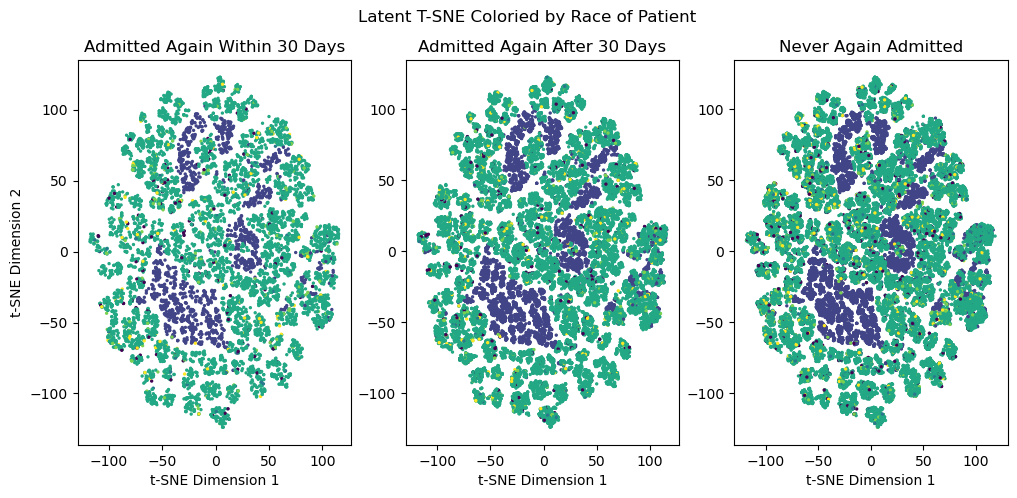

In [5]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.race, "Race of Patient")

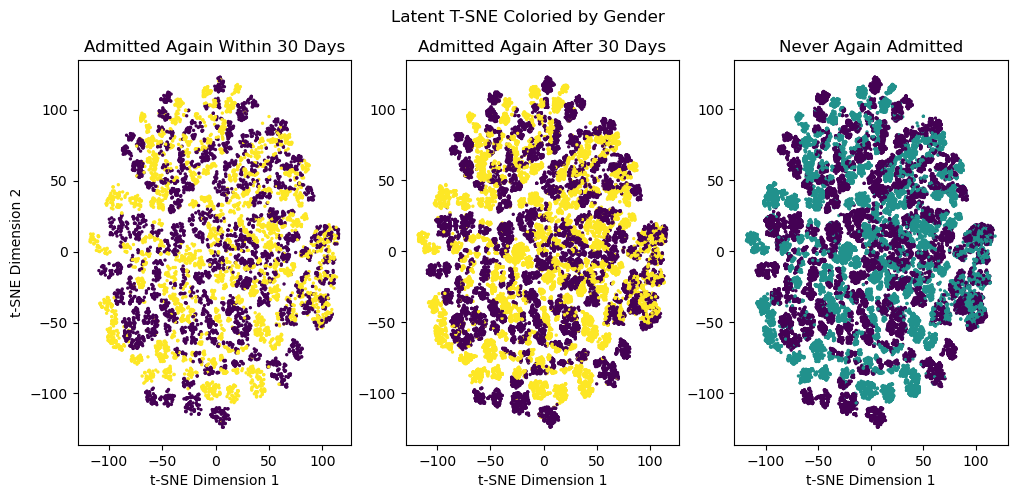

In [6]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.gender, "Gender")

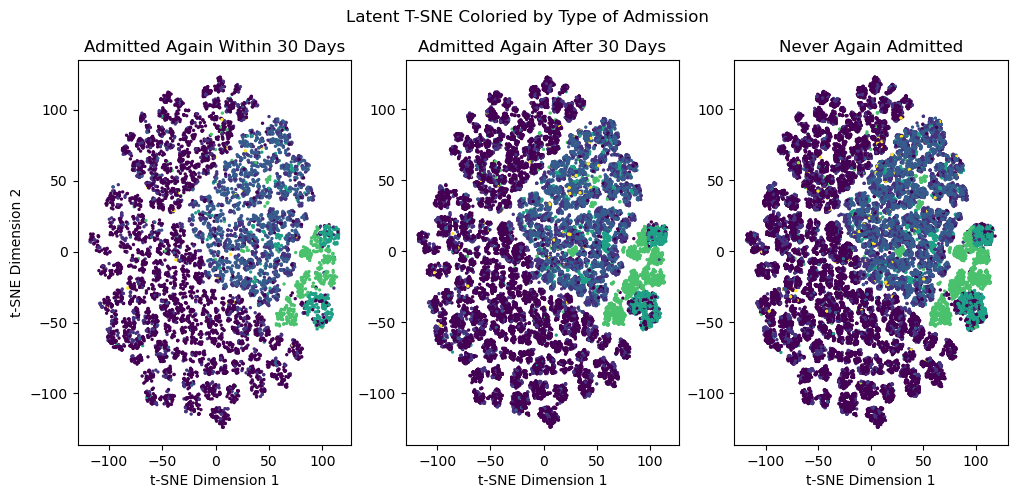

In [7]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.admission_type_id, "Type of Admission")

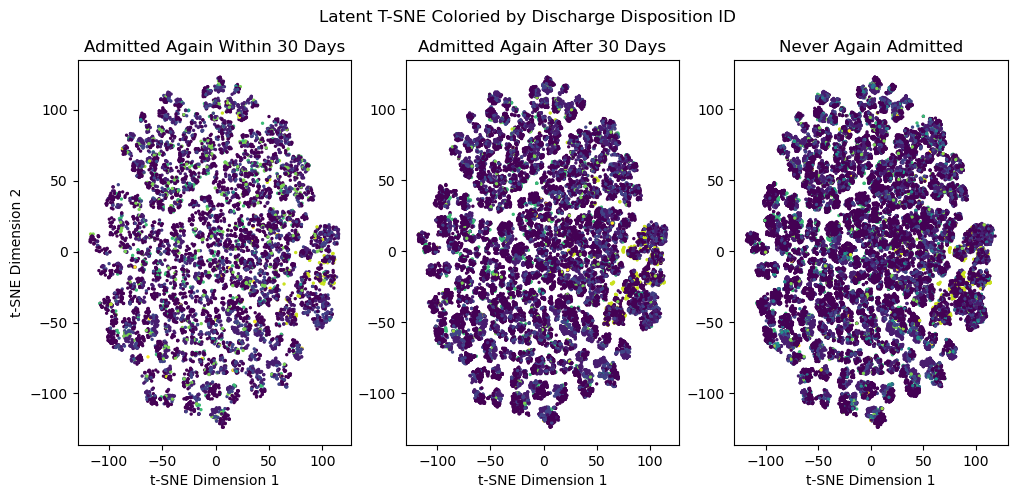

In [8]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.discharge_disposition_id, "Discharge Disposition ID")

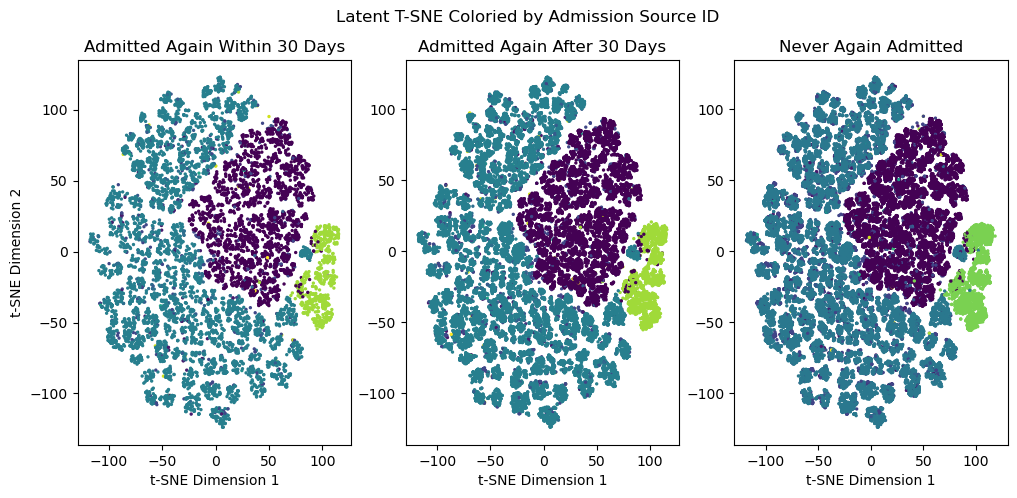

In [9]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.admission_source_id, "Admission Source ID")

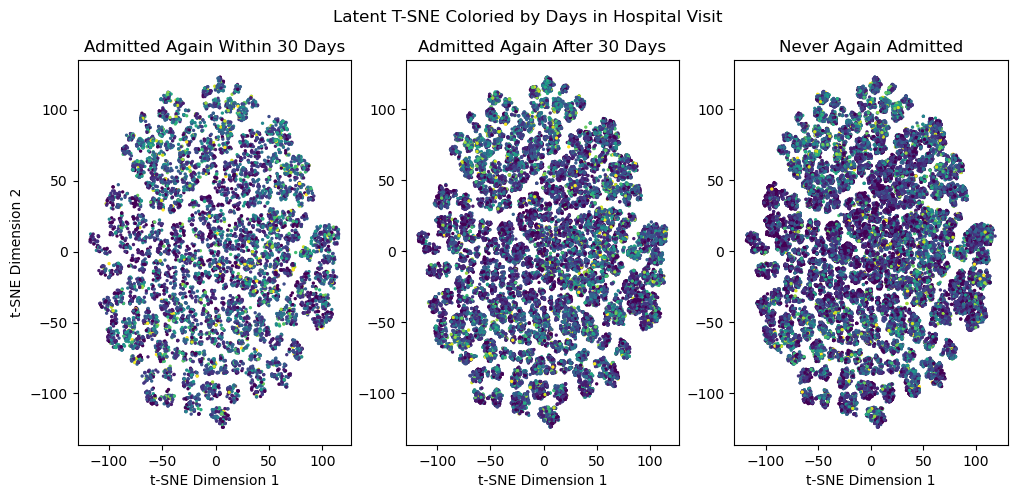

In [10]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.time_in_hospital, "Days in Hospital Visit")

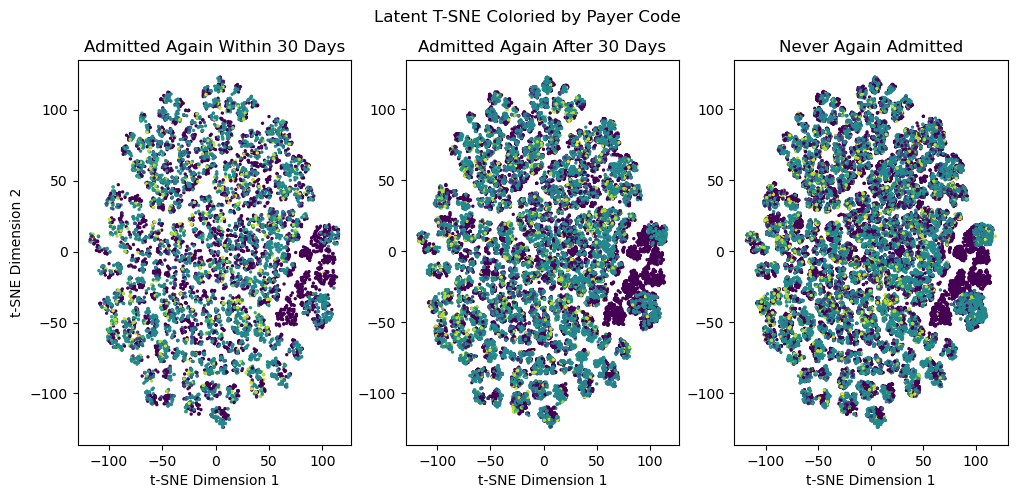

In [11]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.payer_code, "Payer Code")

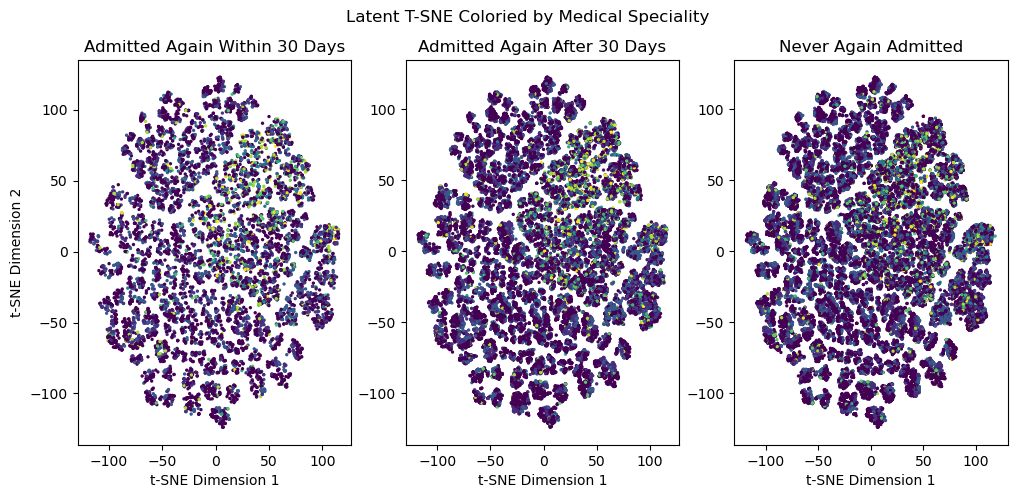

In [12]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.medical_specialty, "Medical Speciality")

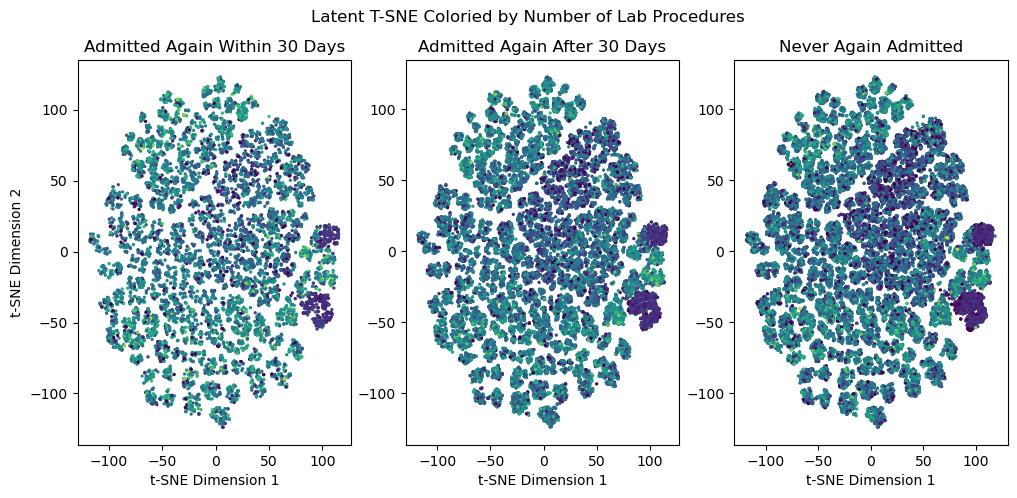

In [13]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.num_lab_procedures, "Number of Lab Procedures")

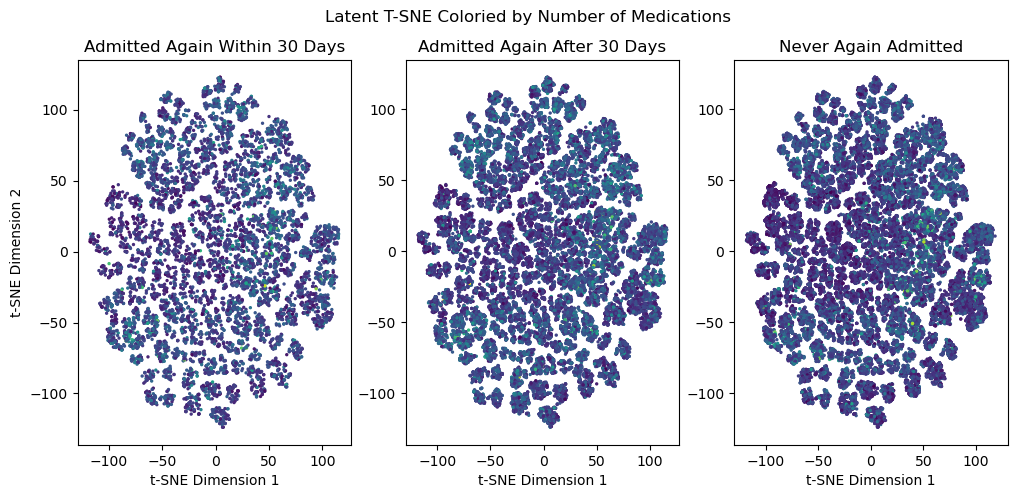

In [14]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.num_medications, "Number of Medications")

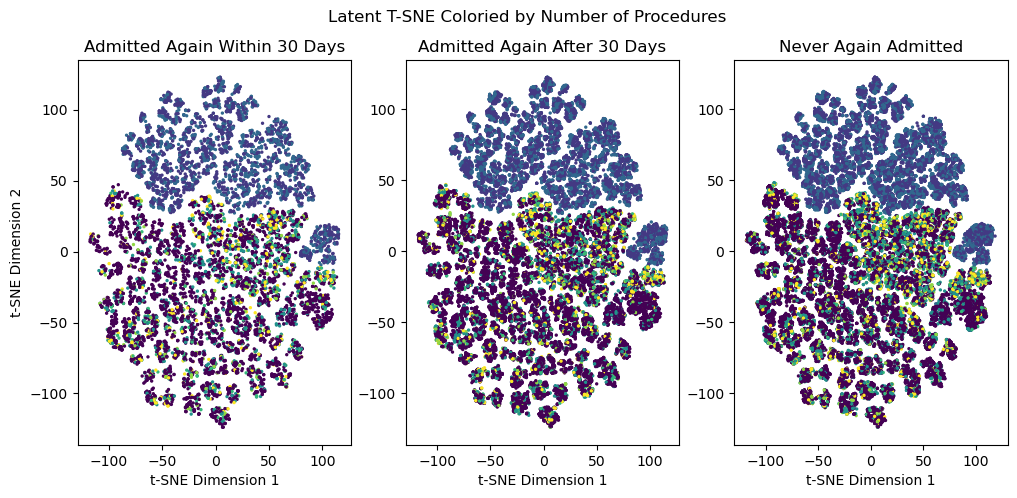

In [15]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.num_procedures, "Number of Procedures")

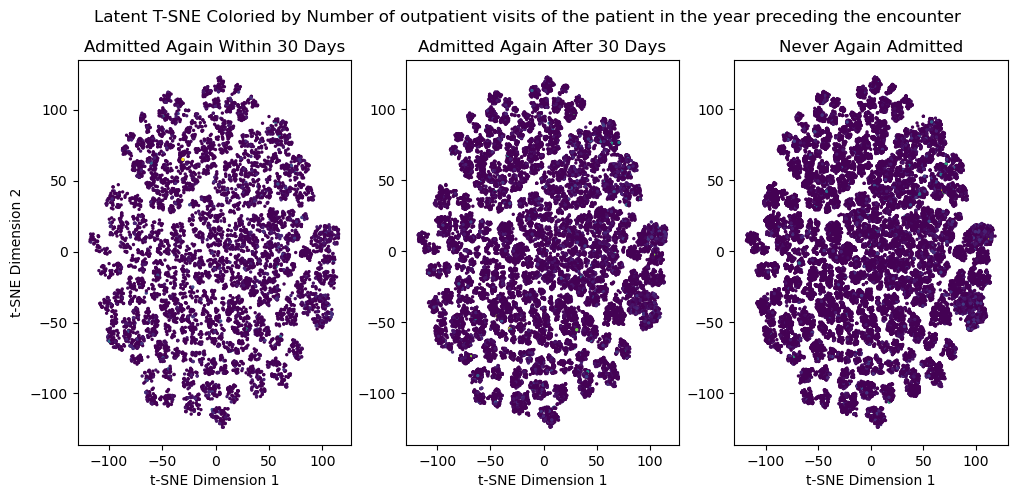

In [16]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.number_outpatient, "Number of outpatient visits of the patient in the year preceding the encounter")

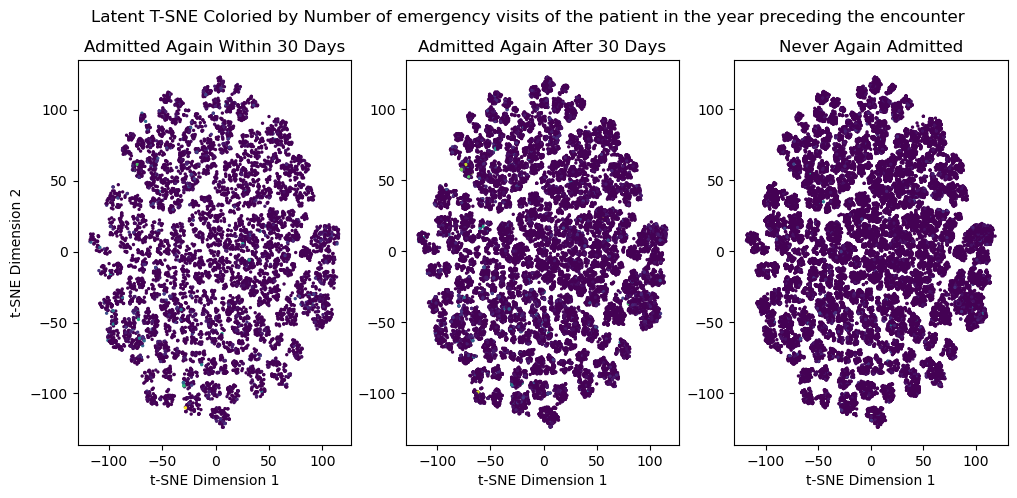

In [17]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.number_emergency, "Number of emergency visits of the patient in the year preceding the encounter")

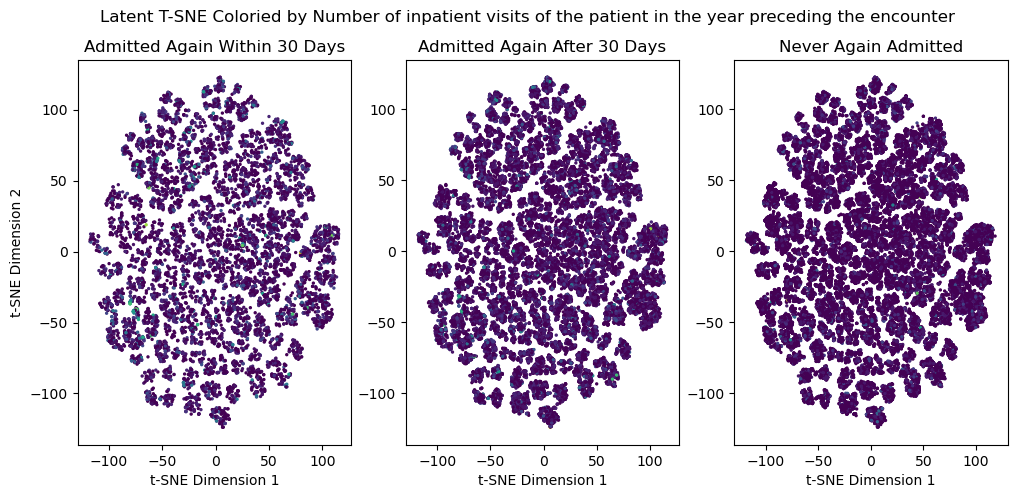

In [18]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.number_inpatient, "Number of inpatient visits of the patient in the year preceding the encounter")

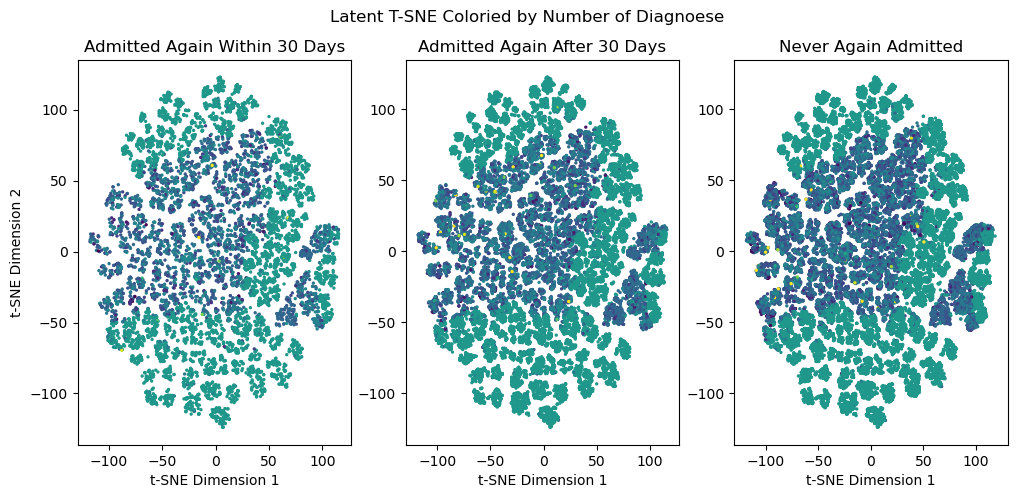

In [19]:
display_tsne_labelled_panels(latent_2d, train_y, train_df.number_diagnoses, "Number of Diagnoese")

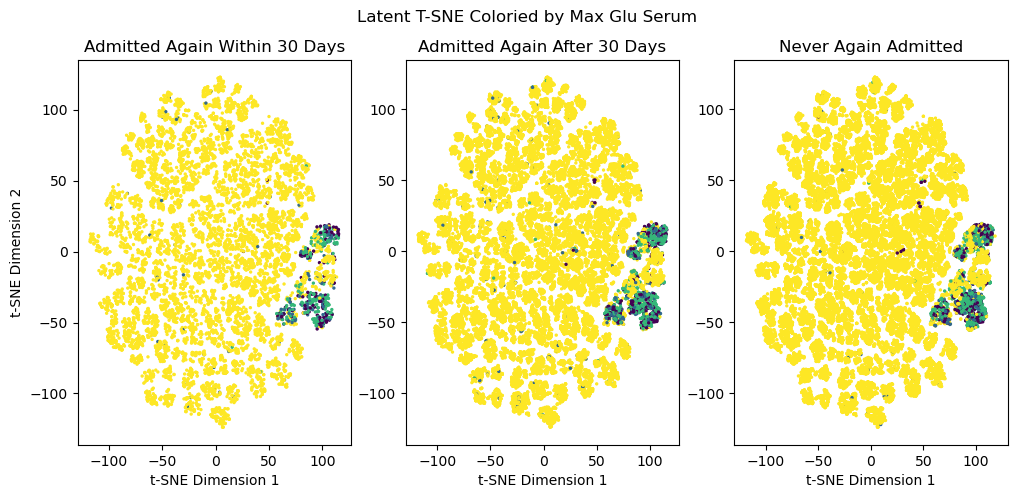

In [20]:
display_tsne_labelled_panels(latent_2d, train_y, [ str(i) for i in train_df.max_glu_serum ], "Max Glu Serum")

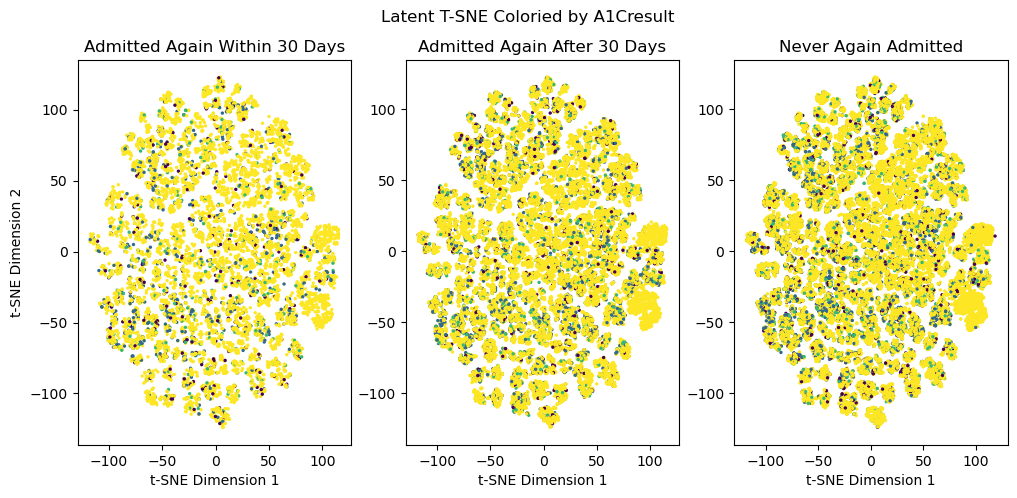

In [21]:
display_tsne_labelled_panels(latent_2d, train_y, [ str(i) for i in train_df.A1Cresult ], "A1Cresult")